# Data Exploratory

Input: transaction data & app data <br>

Purpose: 
1. Understand cleaned transaction data
2. Explore app, in-app and transactions

Output:
App data with ratio of one-time purchase (used in consumer segmentation)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

### Transaction History

In [2]:
df3 = pd.read_csv('CleanedTransaction.csv')
df3.create_dt = pd.to_datetime(df3['create_dt'])
df3.acct_create_dt = pd.to_datetime(df3['acct_create_dt'])

df3.info()

C:\Users\steve\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3331747 entries, 0 to 3331746
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   acct_id                object        
 2   acct_create_dt         datetime64[ns]
 3   payment_type           object        
 4   create_dt              datetime64[ns]
 5   content_id             object        
 6   price                  float64       
 7   device_id              int64         
 8   parent_app_content_id  object        
 9   type                   object        
 10  app_name               object        
 11  category_id            object        
 12  app_device_id          int64         
 13  category_name          object        
 14  app_device_name        object        
 15  _merge                 object        
 16  in-app                 int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(10)
memory usa

<AxesSubplot:>

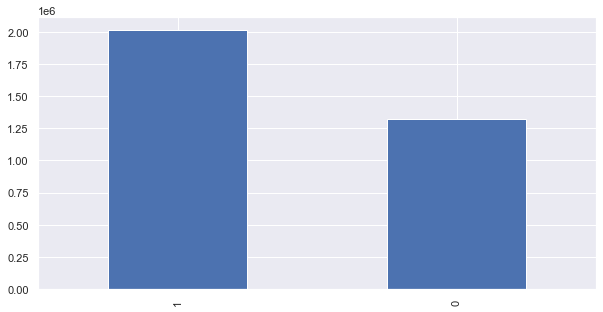

In [3]:
# Understand the ratio between app purchase / download versus in-app purchase

df3['in-app'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))

Text(0.5, 0, 'App Category')

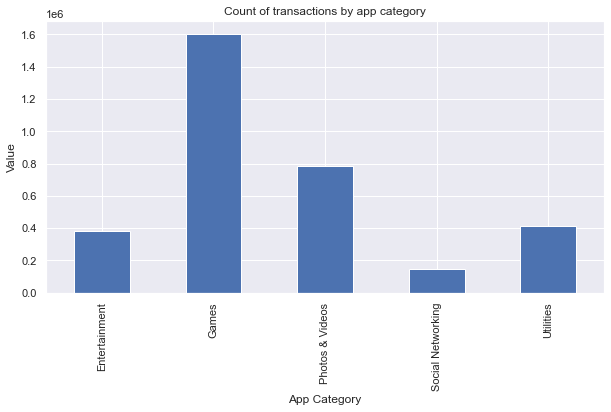

In [4]:
# Count of transactions by app category

df3.price.groupby(df3.category_name).count().plot(kind='bar', figsize=(10,5))
plt.title('Count of transactions by app category')
plt.ylabel('Value')
plt.xlabel('App Category')

Text(0.5, 0, 'App Category')

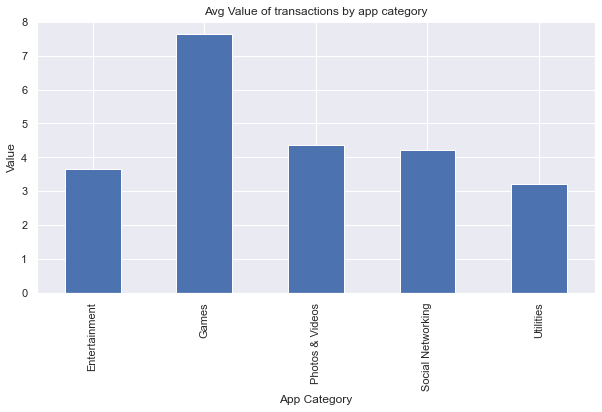

In [5]:
# Average transaction value by app category

df3.price.groupby(df3.category_name).mean().plot(kind='bar', figsize=(10,5))
plt.title('Avg Value of transactions by app category')
plt.ylabel('Value')
plt.xlabel('App Category')

<AxesSubplot:>

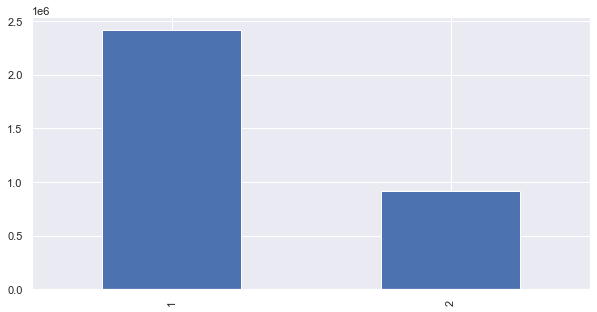

In [6]:
# Understand the ratio of download / purchase by device

df3.device_id.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))

In [7]:
# Understand transaction values / counts by user

ct = df3.groupby('acct_id')['price'].sum().sort_values()
ct.describe()

count    26488.000000
mean       718.400042
std        974.748213
min          0.000000
25%          0.000000
50%       1017.690000
75%       1189.690000
max      11799.750000
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

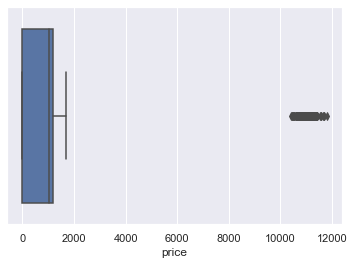

In [8]:
sns.boxplot(x=ct)

#### Review transactions of outliers (w/ high transaction counts & spend)

In [9]:
#150 individauls who spent a lot

cr = df3.groupby('acct_id')['create_dt'].count().sort_values().reset_index()
cr = cr[cr['create_dt'] > 150]
print(cr.tail(5))

b_list =[]
  
#Iterate over each row
for index, rows in cr.iterrows():
    # Create list for the current row
    my_list =rows.acct_id
      
    # append the list to the final list
    b_list.append(my_list)

                acct_id  create_dt
26483  d1a4bbaea275c06c       1340
26484  8422035186298ab9       1343
26485  8574c2b7af1573ac       1347
26486  e2ea593fd4f17918       1351
26487  025488c9dcfdee47       1353


In [10]:
crt = df3.loc[df3.acct_id.isin(b_list),:]
print(crt.shape) #These outliers have 1.4M transactions

(1406391, 17)


In [11]:
crt.payment_type.value_counts() # Finding: they all have payment method on file

PMOF    1406391
Name: payment_type, dtype: int64

C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='createM'>

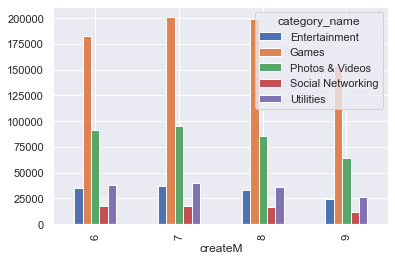

In [12]:
# understand their transactions count by month
crt['createM'] = crt.create_dt.dt.month
crt.groupby(['createM','category_name']).size().unstack().plot(kind="bar")

# Transactions are spread out between 4 months
# No app category has higher number in certain month 

#### Payment type

In [13]:
# Finding: Free only accounts did not make any purchase

df3.groupby('payment_type')['price'].sum()

payment_type
Free only    0.000000e+00
PMOF         1.902898e+07
Name: price, dtype: float64

#### Device type

In [14]:
# Create a dataframe to track if a user downloaded certain app on one or two device
a = df3.groupby(['acct_id','parent_app_content_id'])['device_id'].nunique().reset_index()

print('Total unique app + user: ', a.parent_app_content_id.count())
print('Total unique app + user w/ two devices: ', a[a['device_id'] == 2].parent_app_content_id.count())

# Finding: 5% of apps were downloaded in two devices

Total unique app + user:  2581827
Total unique app + user w/ two devices:  145178


#### Ratio of One-Time Purchase

In [15]:
# Aggregate transaction data to user + app level
a = df3.groupby(['acct_id', 'parent_app_content_id']).agg({'acct_id':'count',
                                                           'price':'mean',
                                                            'create_dt':['max','min']
                                                           }).reset_index()
a.columns = ['acct_id','parent_app_content_id','transct','price_mean','max_create_dt','min_create_dt']

In [16]:
# Convert create_date into datetime format
a.max_create_dt= pd.to_datetime(a['max_create_dt'])
a.min_create_dt = pd.to_datetime(a['min_create_dt'])

In [17]:
# Create one_time indicator if the last purchase data = min purchase date
a['one_time'] = 0
a.loc[a.max_create_dt == a.min_create_dt, ['one_time']] = 1
a['duration'] = (a.max_create_dt - a.min_create_dt).dt.days.astype(int)
a['trans_gap'] = (a['duration']/a.transct).astype(float)


In [18]:
#Aggregate to app level
b = a.groupby(['parent_app_content_id']).agg({'acct_id':'count',
                                            'transct':'mean',
                                            'price_mean':'mean',
                                             'one_time':'sum',
                                             'duration':'mean',
                                             'trans_gap':'mean'}).reset_index()

In [19]:
# Ratio of One-Time purchase
b['ratio_one_time'] = b.one_time / b.acct_id

In [20]:
# Create a new dataframe to store app & ratio of one-time purchase
appnew = b.loc[:,['parent_app_content_id','ratio_one_time']]

# Group apps into 3 based on ratio of one-time purchase
appnew['high_one_time'] = 2
appnew.loc[appnew['ratio_one_time'] > 0.95 ,['high_one_time']] = 1
appnew.loc[appnew['ratio_one_time'] < 0.84 , ['high_one_time']] = 3 # Average
appnew.head()

,parent_app_content_id,ratio_one_time,high_one_time
0,002f3775d84a816a,0.968680,1
1,018cc526b9da06f6,0.963427,1
2,019008a4dabf7c93,0.836085,3
3,019606b1e936b000,0.810865,3
4,01968c31d2a1428c,0.966189,1


In [21]:
appnew.high_one_time.value_counts()

1    380
2    334
3    286
Name: high_one_time, dtype: int64

In [22]:
# Output
appnew.to_csv('appnew.csv')

### App Data Exploratory

In [23]:
app1 = pd.read_csv('app_detail.csv')
app1 = app1.fillna(0) #So apps without in-app purchase shows 0
app1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1000 non-null   int64  
 1   app_name               1000 non-null   object 
 2   parent_app_content_id  1000 non-null   object 
 3   category_id            1000 non-null   object 
 4   app_device_id          1000 non-null   int64  
 5   category_name          1000 non-null   object 
 6   app_device_name        1000 non-null   object 
 7   consumable             1000 non-null   float64
 8   in_app_avail           1000 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 70.4+ KB


#### Understand the percetange of in-app purchase items over total

In [24]:
# Create a new field to show in-app purchase options

app1['in_app'] = 'None'
app1.loc[app1.consumable == 1, 'in_app'] = 'Consumable'
app1.loc[app1.consumable == 2, 'in_app'] = 'Subscription'


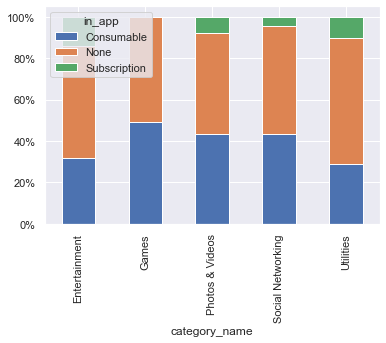

In [25]:
import matplotlib.ticker as mtick


#app1.groupby(['category_name','consumable'])['consumable'].count().unstack().plot(kind='bar',stacked=True)
app1.groupby(['category_name','in_app']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [26]:
# Show price range by in-app purchase options (need transaction data)

dataz = df3.drop(['type','app_device_id','category_name'], axis = 1)
dataz = pd.merge(app1, dataz, on = 'parent_app_content_id', how ='inner' )
dataz.groupby('in_app').agg({'acct_id': 'count',
                                'price':['min','max','mean','sum', 'std']}).reset_index()

in_app  acct_id price                                         
                   count   min    max      mean           sum       std
0    Consumable  1953551  0.00  29.99  8.594682  1.679015e+07  7.537008
1          None  1187042  0.00   9.99  0.863502  1.025013e+06  1.951980
2  Subscription   191154  0.99  28.99  6.349951  1.213818e+06  5.908888

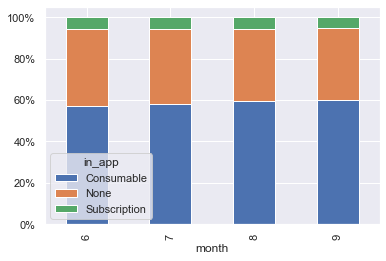

In [27]:
# Transactions by In-app purchase option by Month
dataz['month'] = dataz.create_dt.dt.month

dataz.groupby(['month', 'in_app']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

# does not show difference for certain month

### Popular App Exploratory

Text(0.5, 0, 'App Name')

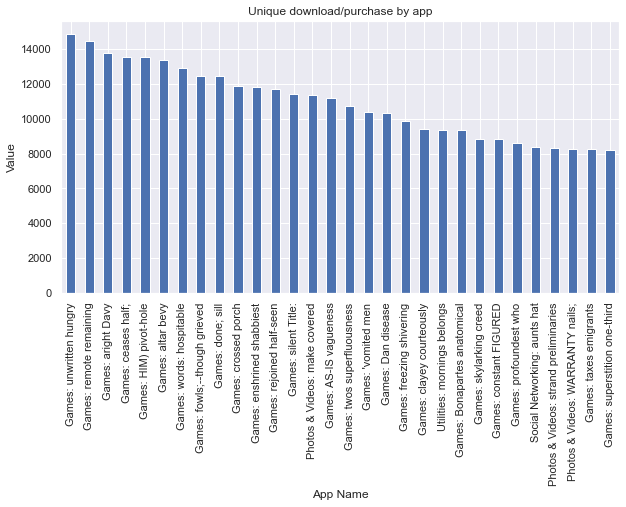

In [28]:
df3['app_cate_name'] = df3['category_name']+': '+df3['app_name']

df3.acct_id.groupby(df3.app_cate_name).nunique().nlargest(30).plot(kind='bar', figsize=(10,5))
plt.title('Unique download/purchase by app')
plt.ylabel('Value')
plt.xlabel('App Name')

#### Market Basket - which apps were often purchased together?

In [29]:
pip install apyori

Note: you may need to restart the kernel to use updated packages.


In [30]:
import apyori
from apyori import apriori

In [31]:
# Create a list to store top 100 popular apps
a = df3.acct_id.groupby(df3.app_cate_name).nunique().nlargest(100).reset_index()

# Create an empty list
a_list =[]
  
# Iterate over each row
for index, rows in a.iterrows():
    # Create list for the current row
    my_list =rows.app_cate_name
      
    # append the list to the final list
    a_list.append(my_list)
    

In [32]:
transactions = df3.loc[df3.app_cate_name.isin(a_list),['acct_id','create_dt','app_cate_name']]

In [33]:
# Take 40% of the users as sample

ind = transactions['acct_id'].value_counts().reset_index().rename(columns = {'index':'acct_id2'})
ind = ind.sample(frac = 0.4)

b_list =[]
  
#Iterate over each row
for index, rows in ind.iterrows():
    # Create list for the current row
    my_list =rows.acct_id2
      
    # append the list to the final list
    b_list.append(my_list)


#transactions.sample(frac = 0.4)
#data1.shape

data1 = transactions.loc[transactions.acct_id.isin(b_list),:]
data1.shape


(487475, 3)

In [34]:
products = data1['app_cate_name'].unique()

In [35]:
# create dummy variables
dummy = pd.get_dummies(data1['app_cate_name'])


data1.drop(['app_cate_name'], inplace =True, axis=1)

data1 = data1.join(dummy)

data1.head()

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,acct_id,create_dt,Entertainment: Acushnet Likewise,Entertainment: Over grandmother,Entertainment: argued drag,Entertainment: castaways massive,Entertainment: evening--it surprise,Entertainment: pegging them;,Games: 'vomited men,Games: 15 Ahasuerus,...,Social Networking: aunts hat,Social Networking: reverberating pipes,Social Networking: thence JAGO'S,Utilities: New laugh?,Utilities: banded ticking,Utilities: chamber chief-mateship,Utilities: colours NE,Utilities: delude right?,Utilities: hen's half-crazy,Utilities: mornings belongs
0,9b6d6fbf76504d85,2016-08-29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9b6d6fbf76504d85,2016-06-17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65cefe068226ffab,2016-08-04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,527fa71ddd4beba6,2016-07-04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,673d26ae5da69699,2016-09-18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
data2 = data1.groupby(['acct_id', 'create_dt'])[products[:]].sum()
data2 = data2.reset_index()[products]

print("New Dimension", data1.shape)
data2.head()

New Dimension (487475, 102)


,Games: ceases half;,Photos & Videos: Michael spiritual,Games: button sensitive,Utilities: mornings belongs,Photos & Videos: strand preliminaries,Games: libraries Grammar,Photos & Videos: Startled systematizer,Games: constant FIGURED,Photos & Videos: go--that's ceremony;,Games: Ross showest,...,Utilities: delude right?,Entertainment: Acushnet Likewise,Games: profoundest who,Games: skylarking creed,Utilities: banded ticking,Games: done; sill,Games: rejoined half-seen,Games: girlish Impossible!,Games: freezing shivering,Games: Bonapartes anatomical
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Map data into the required format of apriori

def product_names(x):
    for product in products:
        if x[product] >0:
            x[product] = product
    return x

data2 = data2.apply(product_names, axis=1)
print("Total Number of Transactions:", len(data2))
data2.head()

Total Number of Transactions: 331818


,Games: ceases half;,Photos & Videos: Michael spiritual,Games: button sensitive,Utilities: mornings belongs,Photos & Videos: strand preliminaries,Games: libraries Grammar,Photos & Videos: Startled systematizer,Games: constant FIGURED,Photos & Videos: go--that's ceremony;,Games: Ross showest,...,Utilities: delude right?,Entertainment: Acushnet Likewise,Games: profoundest who,Games: skylarking creed,Utilities: banded ticking,Games: done; sill,Games: rejoined half-seen,Games: girlish Impossible!,Games: freezing shivering,Games: Bonapartes anatomical
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,Photos & Videos: go--that's ceremony;,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Store multiple purchases into lists
x = data2.values
x = [sub[~(sub==0)].tolist() for sub in x if sub [sub != 0].tolist()]
transactions = x
transactions[0:10]

[["Games: monster night's"],
 ['Games: silent Title:'],
 ['Games: Susan shadows'],
 ["Photos & Videos: go--that's ceremony;",
  "Social Networking: Sleet's perceived"],
 ['Games: Dan disease'],
 ['Utilities: mornings belongs'],
 ['Photos & Videos: paid allay', 'Games: Dan disease'],
 ['Social Networking: reverberating pipes'],
 ['Games: 18 genteel'],
 ['Photos & Videos: applying barbarous;']]

In [39]:
# Set up parameters of apriori 
rules = apriori(transactions, min_support = 0.00006, min_confidence = 0.05, min_lift = 3, max_length = 3, target = "rules")

association_results = list(rules)

In [40]:
# show the association results -> Low support. Need a higher level category

for item in association_results:
    
    pair = item[0]
    items = [x for x in pair]
    
    print("Rule : ", items[0], " -> " + items[1])
    print("Support : ", str(item[1]))
    print("Confidence : ",str(item[2][0][2]))
    print("Lift : ", str(item[2][0][3]))
    
    print("=============================") 

Rule :  Games: ceases half;  -> Photos & Videos: make covered
Support :  6.027400562959213e-05
Confidence :  0.07905138339920949
Lift :  4.118491432997157
Rule :  Photos & Videos: make covered  -> Photos & Videos: WARRANTY nails;
Support :  6.027400562959213e-05
Confidence :  0.1183431952662722
Lift :  4.26135674084253
